# Blockwise Ensemble Methods
Dask-ML provides some ensemble methods that are tailored to dask.array’s and dask.dataframe’s blocked structure. The basic idea is to fit a copy of some sub-estimator to each block (or partition) of the dask Array or DataFrame. Becuase each block fits in memory, the sub-estimator only needs to handle in-memory data structures like a NumPy array or pandas DataFrame. It also will be relatively fast, since each block fits in memory and we won’t need to move large amounts of data between workers on a cluster. We end up with an ensemble of models: one per block in the training dataset.

At prediction time, we combine the results from all the models in the ensemble. For regression problems, this means averaging the predictions from each sub-estimator. For classification problems, each sub-estimator votes and the results are combined. See https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier for details on how they can be combeind. See https://scikit-learn.org/stable/modules/ensemble.html for a general overview of why averaging ensemble methods can be useful.

It’s crucially important that the distribution of values in your dataset be relatively uniform across partitions. Otherwise the parameters learned on any given partition of the data will be poor for the dataset as a whole. This will be shown in detail later.

Let’s randomly generate an example dataset. In practice, you would load the data from storage. We’ll create a dask.array with 10 blocks.



In [2]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client()
client

2022-10-16 20:50:32,873 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/parsanemati/Yandex.Disk.localized/github/data_science_eda/parallel computing /DASK/dask-worker-space/worker-zwg1oy55', purging
2022-10-16 20:50:32,873 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/parsanemati/Yandex.Disk.localized/github/data_science_eda/parallel computing /DASK/dask-worker-space/worker-13rt0s8e', purging
2022-10-16 20:50:32,874 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/parsanemati/Yandex.Disk.localized/github/data_science_eda/parallel computing /DASK/dask-worker-space/worker-fdbhlg43', purging
2022-10-16 20:50:32,874 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/parsanemati/Yandex.Disk.localized/github/data_science_eda/parallel computing /DASK/dask-worker-space/worker-0a6oxgnm', purging
2022-10-16 20:50:32,874 - distributed.diskutils - INFO - Found stale lock file and direc

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57071,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:57096,Total threads: 2
Dashboard: http://127.0.0.1:57101/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:57078,


In [6]:
from distributed import Client
import dask_ml.datasets
import dask_ml.ensemble

client = Client(n_workers=4, threads_per_worker=1)

X, y = dask_ml.datasets.make_classification(n_samples=1_000_000,
                                            n_informative=10,
                                            shift=2, scale=2,
                                            chunks=100_000)
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

## Classification
The sub-estimator should be an instantiated scikit-learn-API compatible estimator (anything that implements the fit / predict API, including pipelines). It only needs to handle in-memory datasets. We’ll use sklearn.linear_model.RidgeClassifier.

To get the output shapes right, we require that you provide the classes for classification problems, either when creating the estimator or in .fit if the sub-estimator also requires the classes.

In [7]:
import sklearn.linear_model

subestimator = sklearn.linear_model.RidgeClassifier(random_state=0)
clf = dask_ml.ensemble.BlockwiseVotingClassifier(
    subestimator,
    classes=[0, 1]
)
clf

BlockwiseVotingClassifier(classes=[0, 1],
                          estimator=RidgeClassifier(random_state=0))

In [8]:
clf.fit(X, y)
# All of the fitted estimators are available at .estimators_.

clf.estimators_

[RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0),
 RidgeClassifier(random_state=0)]

These are different estimators! They’ve been trained on separate batches of data and have learned different parameters. We can plot the difference in the learned coef_ of the first two models to visualize this.


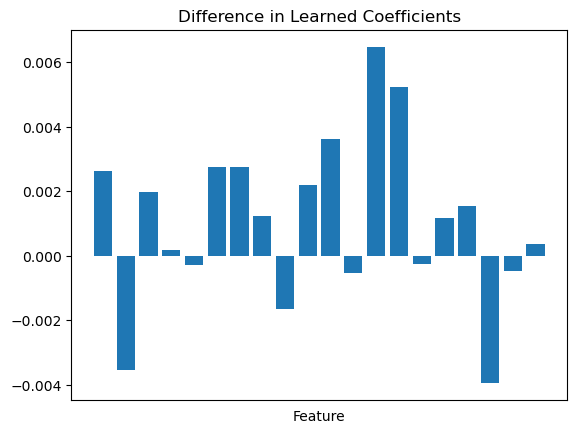

In [9]:

import matplotlib.pyplot as plt
import numpy as np
a = clf.estimators_[0].coef_
b = clf.estimators_[1].coef_

fig, ax = plt.subplots()
ax.bar(np.arange(a.shape[1]), (a - b).ravel())
ax.set(xticks=[], xlabel="Feature", title="Difference in Learned Coefficients");

That said, the assumption backing this entire process is that the distribution of the data is relatively uniform across partitions. The parameters learned by the each member of the ensemble should be relatively similar, and so will give relatively similar predictions when applied to the same data.

When you predict, the result will have the same chunking pattern as the input array you’re predicting for (which need not match the partitioning of the training data).


In [10]:
preds = clf.predict(X)
preds

dask.array<_vote_block, shape=(1000000,), dtype=int64, chunksize=(100000,), chunktype=numpy.ndarray>

In [11]:
clf.score(X, y)


0.859563

This generates a set of tasks that

1. Calls subestimator.predict(chunk) for each subestimator (10 in our case)

2. Concatenates those predictions together

3. Somehow averages the predictions to a single overall prediction

We used the default voting="hard" strategy, which means we just choose the class that had the higest number of votes. If the first two sub-estimators picked class 0 and the other eight picked class 1 for the first row, the final prediction for that row will be class 1.

In [12]:
subestimator = sklearn.linear_model.LogisticRegression(random_state=0)
clf = dask_ml.ensemble.BlockwiseVotingClassifier(
    subestimator,
    classes=[0, 1],
    voting="soft"
)
clf.fit(X, y)
proba = clf.predict_proba(X)
proba[:5].compute()

array([[0.99896672, 0.00103328],
       [0.8627522 , 0.1372478 ],
       [0.01388675, 0.98611325],
       [0.28404358, 0.71595642],
       [0.15548367, 0.84451633]])

In [13]:
clf.score(X, y)


0.859556

In [14]:
clf_predict = clf.predict(X)
clf_predict[:5].compute()

array([0, 0, 1, 1, 1])

In [15]:
subestimator = sklearn.linear_model.LogisticRegression(random_state=0)
clf = dask_ml.ensemble.BlockwiseVotingClassifier(
    subestimator,
    classes=[0, 1],
    voting="hard"
)
clf.fit(X, y)
clf_predict = clf.predict(X)
clf_predict[:5].compute()

array([0, 0, 1, 1, 1])

In [16]:
clf.score(X, y)


0.859531

## Regression
Regression is quite similar. The primary difference is that there’s no voting; predictions from estimators are always reduced by averaging.



In [17]:
X, y = dask_ml.datasets.make_regression(n_samples=1_000_000,
                                        chunks=100_000,
                                        n_features=20)
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

In [18]:
subestimator = sklearn.linear_model.LinearRegression()
clf = dask_ml.ensemble.BlockwiseVotingRegressor(
    subestimator,
)
clf.fit(X, y)
clf.predict(X)[:5].compute()


array([-110.63436288, -198.88182039,  177.43944755,  145.51251603,
       -266.08539714])

In [19]:
clf.score(X, y)


1.0

## The dangers of non-uniformly distributed data
Finally, it must be re-emphasized that your data should be uniformly distributed across partitoins prior to using these ensemble methods. If it’s not, then you’re better off just sampling rows from each partition and fitting a single classifer to it. By “uniform” we don’t mean “from a uniform probabillity distribution”. Just that there shouldn’t be a clear per-partition pattern to how the data is distributed.

Let’s demonstrate that with an example. We’ll generate a dataset with a clear trend across partitions. This might represent some non-stationary time-series, though it can occur in other contexts as well (e.g. on data partitioned by geography, age, etc.)

In [4]:
import dask.array as da
import dask.delayed
import sklearn.datasets
def clone_and_shift(X, y, i):
    X = X.copy()
    X += i + np.random.random(X.shape)
    y += 25 * (i + np.random.random(y.shape))
    return X, y
# Make a base dataset that we'll clone and shift
X, y = sklearn.datasets.make_regression(n_features=4, bias=2, random_state=0)

# Clone and shift 10 times, gradually increasing X and y for each partition
Xs, ys = zip(*[dask.delayed(clone_and_shift, nout=2)(X, y, i) for i in range(10)])
Xs = [da.from_delayed(x, shape=X.shape, dtype=X.dtype) for x in Xs]
ys = [da.from_delayed(y_, shape=y.shape, dtype=y.dtype) for y_ in ys]
X2 = da.concatenate(Xs)
y2 = da.concatenate(ys)

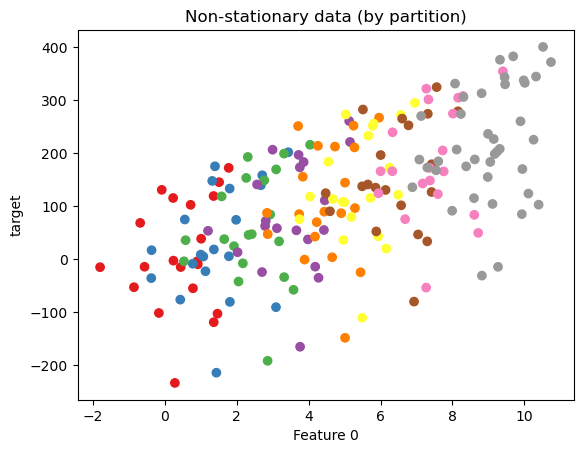

In [21]:
fig, ax = plt.subplots()
ax.scatter(X2[::5, 0], y2[::5], c=np.arange(0, len(X2), 5) // 100, cmap="Set1",
           label="Partition")
ax.set(xlabel="Feature 0", ylabel="target", title="Non-stationary data (by partition)");

Now let’s fit two estimators:

1. One BlockwiseVotingRegressor on the entire dataset (which fits a LinearRegression on each partition)

2. One LinearRegression on a sample from the entire dataset

In [22]:
subestimator = sklearn.linear_model.LinearRegression()
clf = dask_ml.ensemble.BlockwiseVotingRegressor(
    subestimator,
)
clf.fit(X2, y2)
X_sampled, y_sampled = dask.compute(X2[::10], y2[::10])

subestimator.fit(X_sampled, y_sampled)

LinearRegression()

In [23]:
clf.score(X2, y2)


-11.526217699086157

In [24]:
subestimator.score(X2, y2)

0.13107690294127794

This shows that ensuring your needs to be relatively uniform across partitions. Even including the standard controls to normalize whatever underlying force is generating the non-stationary data (e.g. a time trend compontent or differencing timeseries data, dummy variables for geographic regions, etc) is not sufficient when your dataset is partioned by the non-uniform variable. You would still need to either shuffle your data prior to fitting, or just sample and fit the sub-estimator on the sub-sample that fits in memory.

# Scale Scikit-Learn for Small Data Problems
This example demonstrates how Dask can scale scikit-learn to a cluster of machines for a CPU-bound problem. We’ll fit a large model, a grid-search over many hyper-parameters, on a small dataset.

This video talks demonstrates the same example on a larger cluster.

In [10]:
## Create Scikit-Learn Pipeline
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57298/status,
Dashboard: http://127.0.0.1:57298/status,Workers: 4
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57299,Workers: 4
Dashboard: http://127.0.0.1:57298/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:57316,Total threads: 1
Dashboard: http://127.0.0.1:57319/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:57302,


In [11]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Scale Up: set categories=None to use all the categories
categories = [
    'alt.atheism',
    'talk.religion.misc',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories



In [12]:
pipeline = Pipeline([
    ('vect', HashingVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000)),
])

## Define Grid for Parameter Search
Grid search over some parameters.

In [13]:
parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    # 'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__n_iter': (10, 50, 80),
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=False)


In [14]:
grid_search.fit(data.data, data.target)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', HashingVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1e-05, 1e-06),
                         'tfidf__norm': ('l1', 'l2'),
                         'tfidf__use_idf': (True, False)},
             refit=False, verbose=1)

In [15]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(data.data, data.target)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', HashingVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1e-05, 1e-06),
                         'tfidf__norm': ('l1', 'l2'),
                         'tfidf__use_idf': (True, False)},
             refit=False, verbose=1)

If you had your distributed dashboard open during that fit, you’ll notice that each worker performs some of the fit tasks.



## Parallel, Distributed Prediction
Sometimes, you’re train on a small dataset, but need to predict for a much larger batch of data. In this case, you’d like your estimator to handle NumPy arrays and pandas DataFrames for training, and dask arrays or DataFrames for prediction. `dask_ml.wrappers.ParallelPostFit <http://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html#dask_ml.wrappers.ParallelPostFit>`__ provides exactly that. It’s a meta-estimator. It does nothing during training; the underlying estimator (probably a scikit-learn estimator) will probably be in-memory on a single machine. But tasks like predict, score, etc. are parallelized and distributed.

Most of the time, using ParallelPostFit is as simple as wrapping the original estimator. When used inside a GridSearch, you’ll need to update the keys of the parameters, just like with any meta-estimator. The only complication comes when using ParallelPostFit with another meta-estimator like GridSearchCV. In this case, you’ll need to prefix your parameter names with estimator__.


In [17]:

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from dask_ml.wrappers import ParallelPostFit
# We’ll load the small NumPy arrays for training.

X, y = load_digits(return_X_y=True)
X.shape


(1797, 64)

In [18]:
svc = ParallelPostFit(SVC(random_state=0, gamma='scale'))

param_grid = {
    # use estimator__param instead of param
    'estimator__C': [0.01, 1.0, 10],
}

grid_search = GridSearchCV(svc, param_grid, cv=3)

In [19]:
grid_search.fit(X, y)


GridSearchCV(cv=3, estimator=ParallelPostFit(estimator=SVC(random_state=0)),
             param_grid={'estimator__C': [0.01, 1.0, 10]})

We’ll simulate a large dask array by replicating the training data a few times. In reality, you would load this from your file system.


In [20]:

import dask.array as da
big_X = da.concatenate([
    da.from_array(X, chunks=X.shape)
    for _ in range(10)
])
big_X

dask.array<concatenate, shape=(17970, 64), dtype=float64, chunksize=(1797, 64), chunktype=numpy.ndarray>

Operations like predict, or predict_proba return dask, rather than NumPy arrays. When you compute, the work will be done in parallel, out of core or distributed on the cluster.



In [21]:
predicted = grid_search.predict(big_X)
predicted

dask.array<_predict, shape=(17970,), dtype=int64, chunksize=(1797,), chunktype=numpy.ndarray>

In [25]:
predicted.compute()

array([0, 1, 2, ..., 8, 9, 8])

In [ ]:
predicted.compute()

In [24]:
predicted.shape

(17970,)

In [ ]:
https://examples.dask.org/machine-learning/parallel-prediction.html